In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
train_df = pd.read_csv('df_train.csv')
test_df = pd.read_csv('df_test_clean.csv')

print(train_df.head())
print(test_df.head())

         Order ID Order Month    Sales        Country         Category  \
0  CA-2014-146591      2014/1  108.720  United States  Office Supplies   
1  CA-2014-135405      2014/1    9.344  United States  Office Supplies   
2  CA-2014-135405      2014/1   31.200  United States       Technology   
3  CA-2014-167927      2014/1   66.580  United States  Office Supplies   
4  CA-2014-167927      2014/1   43.920  United States  Office Supplies   

  Customer ID  
0    TS-21340  
1    MS-17830  
2    MS-17830  
3    XP-21865  
4    XP-21865  
  Order Month  Sales
0      2017/1    NaN
1     2017/10    NaN
2     2017/11    NaN
3     2017/12    NaN
4      2017/2    NaN


In [46]:
train_df['Order Month'] = pd.to_datetime(train_df['Order Month'])
monthly_sales = train_df.groupby('Order Month')['Sales'].sum().reset_index()
print(monthly_sales.head())

  Order Month      Sales
0  2014-01-01  14236.895
1  2014-02-01   4519.892
2  2014-03-01  55691.009
3  2014-04-01  28295.345
4  2014-05-01  23648.287


C:\Users\miche\AppData\Local\Temp\ipykernel_20812\573539733.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['Order Month'] = pd.to_datetime(train_df['Order Month'])


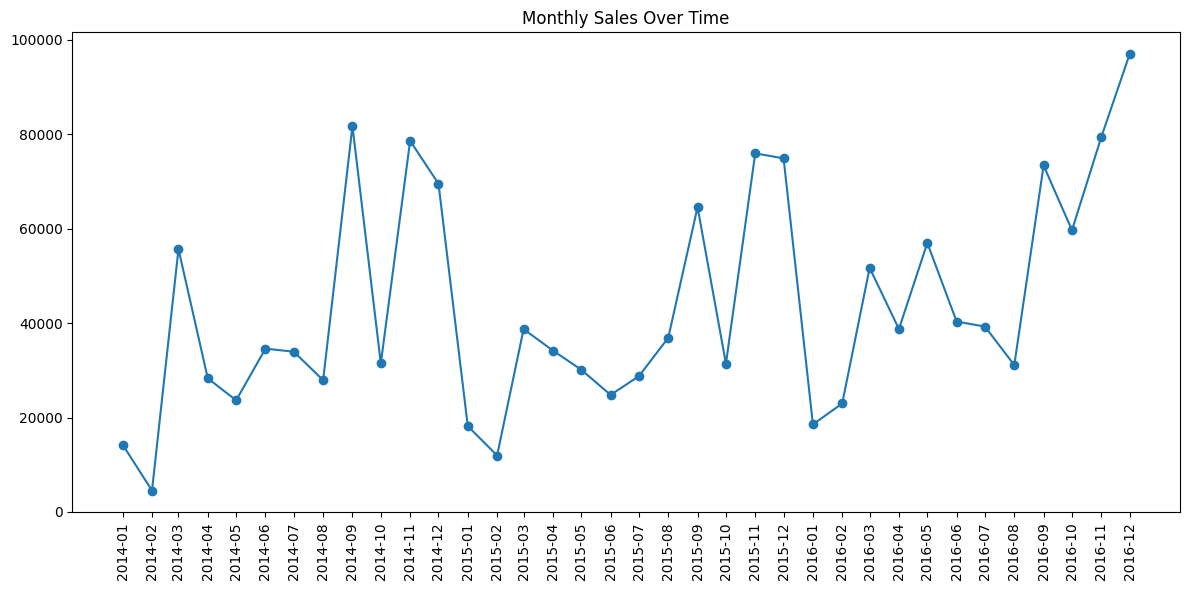

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Order Month'], monthly_sales['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xticks(monthly_sales['Order Month'], monthly_sales['Order Month'].dt.strftime('%Y-%m'), rotation=90)
plt.tight_layout()
plt.show()

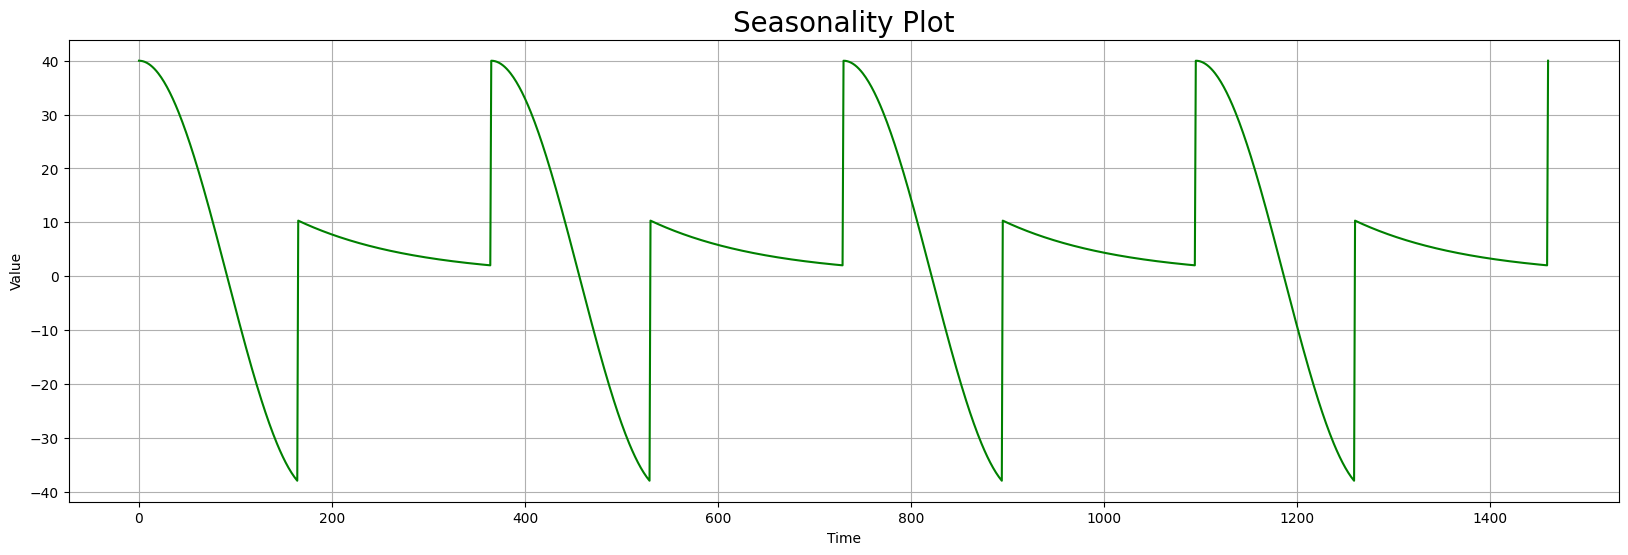

In [48]:
def plot_series(time, series, format="-", start=0, end=None, label=None, color=None):
    plt.plot(time[start:end], series[start:end], format, label=label, color=color)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.45,
                   np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

# Definiowanie czasu dla analizy sezonowości
time = np.arange(4 * 365 + 1, dtype="float32")  # 4 lata danych

amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude, phase=0)
plt.figure(figsize=(20, 6))
plot_series(time, series, color="green")
plt.title("Seasonality Plot", fontdict={'fontsize': 20})
plt.show()

In [49]:
monthly_sales['Month'] = monthly_sales['Order Month'].dt.month
monthly_sales['Year'] = monthly_sales['Order Month'].dt.year

monthly_sales["is_december"] = (monthly_sales['Month'] == 12).astype(int)
monthly_sales["is_january"] = (monthly_sales['Month'] == 1).astype(int)
monthly_sales['is_q4'] = monthly_sales['Month'].isin([10, 11, 12]).astype(int)
monthly_sales['is_q1'] = monthly_sales['Month'].isin([1, 2, 3]).astype(int)

monthly_sales['lag_1'] = monthly_sales['Sales'].shift(1)
monthly_sales['lag_2'] = monthly_sales['Sales'].shift(2)
monthly_sales['lag_3'] = monthly_sales['Sales'].shift(3)
monthly_sales['lag_6'] = monthly_sales['Sales'].shift(6)
monthly_sales['lag_12'] = monthly_sales['Sales'].shift(12) 


monthly_sales['time_trend'] = range(len(monthly_sales))

monthly_sales['rolling_mean_3'] = monthly_sales['Sales'].rolling(window=3, min_periods=1).mean()
monthly_sales['rolling_mean_6'] = monthly_sales['Sales'].rolling(window=6, min_periods=1).mean()
monthly_sales['rolling_mean_12'] = monthly_sales['Sales'].rolling(window=12, min_periods=1).mean()

monthly_sales = monthly_sales.dropna()

In [50]:
# # 1. Dodajmy więcej features i spróbujmy ensemble
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
# import numpy as np

# # Dodatkowe features
# monthly_sales['month_sin'] = np.sin(2 * np.pi * monthly_sales['Month'] / 12)
# monthly_sales['month_cos'] = np.cos(2 * np.pi * monthly_sales['Month'] / 12)
# monthly_sales['is_peak_season'] = monthly_sales['Month'].isin([11, 12, 1]).astype(int)
# monthly_sales['is_low_season'] = monthly_sales['Month'].isin([2, 3, 4]).astype(int)
# monthly_sales['quarter'] = ((monthly_sales['Month'] - 1) // 3 + 1)

# # Interakcje
# monthly_sales['trend_x_month'] = monthly_sales['time_trend'] * monthly_sales['Month']
# monthly_sales['trend_squared'] = monthly_sales['time_trend'] ** 2

# # Usuwamy NaN
# monthly_sales = monthly_sales.dropna()

# # Nowe features
# features = ['Month', 'Year', 'is_december', 'is_january', 'is_q4', 'is_q1',
#            'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'time_trend',
#            'rolling_mean_3', 'rolling_mean_6', 'rolling_mean_12',
#            'month_sin', 'month_cos', 'is_peak_season', 'is_low_season', 
#            'quarter', 'trend_x_month', 'trend_squared']

# X = monthly_sales[features]
# y = monthly_sales['Sales']

# print(f"Nowy kształt danych: X={X.shape}, y={y.shape}")

# # 2. Lepsze parametry XGBoost dla małego datasetu
# xgb_params_tuned = {
#     'objective': 'reg:squarederror',
#     'max_depth': 3,  # Zmniejszone żeby uniknąć overfitting
#     'learning_rate': 0.05,  # Wolniejsze uczenie
#     'n_estimators': 100,  # Mniej drzew
#     'subsample': 0.9,
#     'colsample_bytree': 0.9,
#     'random_state': 42,
#     'reg_alpha': 0.5,  # Większa regularyzacja
#     'reg_lambda': 0.5
# }

# # 3. Ensemble różnych modeli
# models = {
#     'XGBoost': xgb.XGBRegressor(**xgb_params_tuned),
#     'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
#     'Linear': LinearRegression()
# }

# # Cross-validation dla każdego modelu
# tscv = TimeSeriesSplit(n_splits=3)
# results = {}

# for model_name, model in models.items():
#     cv_mae_scores = []
#     cv_mape_scores = []
    
#     for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
#         X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
#         y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
#         model.fit(X_train_fold, y_train_fold)
#         y_pred = model.predict(X_val_fold)
        
#         mae = mean_absolute_error(y_val_fold, y_pred)
#         mape = mean_absolute_percentage_error(y_val_fold, y_pred) * 100
        
#         cv_mae_scores.append(mae)
#         cv_mape_scores.append(mape)
    
#     results[model_name] = {
#         'MAE': np.mean(cv_mae_scores),
#         'MAPE': np.mean(cv_mape_scores),
#         'MAE_std': np.std(cv_mae_scores),
#         'MAPE_std': np.std(cv_mape_scores)
#     }
    
#     print(f"{model_name}:")
#     print(f"  MAE: {np.mean(cv_mae_scores):.0f} ± {np.std(cv_mae_scores):.0f}")
#     print(f"  MAPE: {np.mean(cv_mape_scores):.2f}% ± {np.std(cv_mape_scores):.2f}%")
#     print()

# # 4. Ensemble prediction
# ensemble_predictions = []
# for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
#     X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
#     y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
#     fold_predictions = []
#     for model_name, model in models.items():
#         model.fit(X_train_fold, y_train_fold)
#         pred = model.predict(X_val_fold)
#         fold_predictions.append(pred)
    
#     # Średnia z wszystkich modeli
#     ensemble_pred = np.mean(fold_predictions, axis=0)
#     ensemble_predictions.extend(ensemble_pred)

# # Oblicz metryki dla ensemble (trzeba będzie je dopasować do validation setów)
# print("Czy to pomogło? Sprawdźmy najlepszy model...")

In [51]:
# # Sprawdźmy dlaczego Linear Regression jest tak dobra
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

# # 1. Linear Regression z normalizacją (może to pomóc)
# linear_scaled = Pipeline([
#     ('scaler', StandardScaler()),
#     ('linear', LinearRegression())
# ])

# # 2. Sprawdźmy ensemble Linear + najlepszy tree model
# models_final = {
#     'Linear': LinearRegression(),
#     'Linear_Scaled': linear_scaled,
#     'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
#     'XGBoost_Tuned': xgb.XGBRegressor(**xgb_params_tuned)
# }

# # Dokładniejsze CV
# tscv = TimeSeriesSplit(n_splits=3)
# detailed_results = {}
# all_predictions = {}

# for model_name, model in models_final.items():
#     cv_mae_scores = []
#     cv_mape_scores = []
#     fold_predictions = []
#     fold_actuals = []
    
#     print(f"\n=== {model_name} ===")
    
#     for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
#         X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
#         y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
#         model.fit(X_train_fold, y_train_fold)
#         y_pred = model.predict(X_val_fold)
        
#         mae = mean_absolute_error(y_val_fold, y_pred)
#         mape = mean_absolute_percentage_error(y_val_fold, y_pred) * 100
        
#         cv_mae_scores.append(mae)
#         cv_mape_scores.append(mape)
#         fold_predictions.extend(y_pred)
#         fold_actuals.extend(y_val_fold)
        
#         print(f"  Fold {fold+1}: MAE={mae:.0f}, MAPE={mape:.2f}%")
    
#     detailed_results[model_name] = {
#         'MAE_mean': np.mean(cv_mae_scores),
#         'MAPE_mean': np.mean(cv_mape_scores),
#         'MAE_std': np.std(cv_mae_scores),
#         'MAPE_std': np.std(cv_mape_scores),
#         'predictions': fold_predictions,
#         'actuals': fold_actuals
#     }
    
#     print(f"  Średnia: MAE={np.mean(cv_mae_scores):.0f}±{np.std(cv_mae_scores):.0f}, MAPE={np.mean(cv_mape_scores):.2f}%±{np.std(cv_mape_scores):.2f}%")

# # 3. Wybierz najlepszy model na podstawie MAPE
# best_model_name = min(detailed_results.keys(), 
#                      key=lambda x: detailed_results[x]['MAPE_mean'])

# print(f"\n🏆 NAJLEPSZY MODEL: {best_model_name}")
# print(f"MAE: {detailed_results[best_model_name]['MAE_mean']:.0f}")
# print(f"MAPE: {detailed_results[best_model_name]['MAPE_mean']:.2f}%")

# # 4. Trenuj finalny model na wszystkich danych
# final_model = models_final[best_model_name]
# final_model.fit(X, y)

# print(f"\nModel {best_model_name} wytrenowany na wszystkich danych!")
# print("Gotowy do predykcji na 2017!")

# # 5. Sprawdź feature importance jeśli to możliwe
# if hasattr(final_model, 'feature_importances_'):
#     importance_df = pd.DataFrame({
#         'feature': features,
#         'importance': final_model.feature_importances_
#     }).sort_values('importance', ascending=False)
#     print("\nNajważniejsze cechy:")
#     print(importance_df.head(8))
# elif hasattr(final_model, 'coef_'):
#     coef_df = pd.DataFrame({
#         'feature': features,
#         'coefficient': final_model.coef_
#     }).sort_values('coefficient', key=abs, ascending=False)
#     print("\nNajważniejsze współczynniki:")
#     print(coef_df.head(8))

=== TRENOWANIE FINALNEGO RANDOM FOREST ===
Szukam najlepszych parametrów...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Najlepsze parametry: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}
Najlepszy wynik CV MAE: 16902

Finalny Random Forest: RandomForestRegressor(max_depth=3, n_estimators=50, random_state=42)

=== TOP 10 NAJWAŻNIEJSZYCH CECH ===
lag_12              : 0.3821
Month               : 0.1908
trend_x_month       : 0.0979
rolling_mean_3      : 0.0799
trend_squared       : 0.0539
rolling_mean_6      : 0.0373
is_q4               : 0.0328
rolling_mean_12     : 0.0223
month_cos           : 0.0165
time_trend          : 0.0161


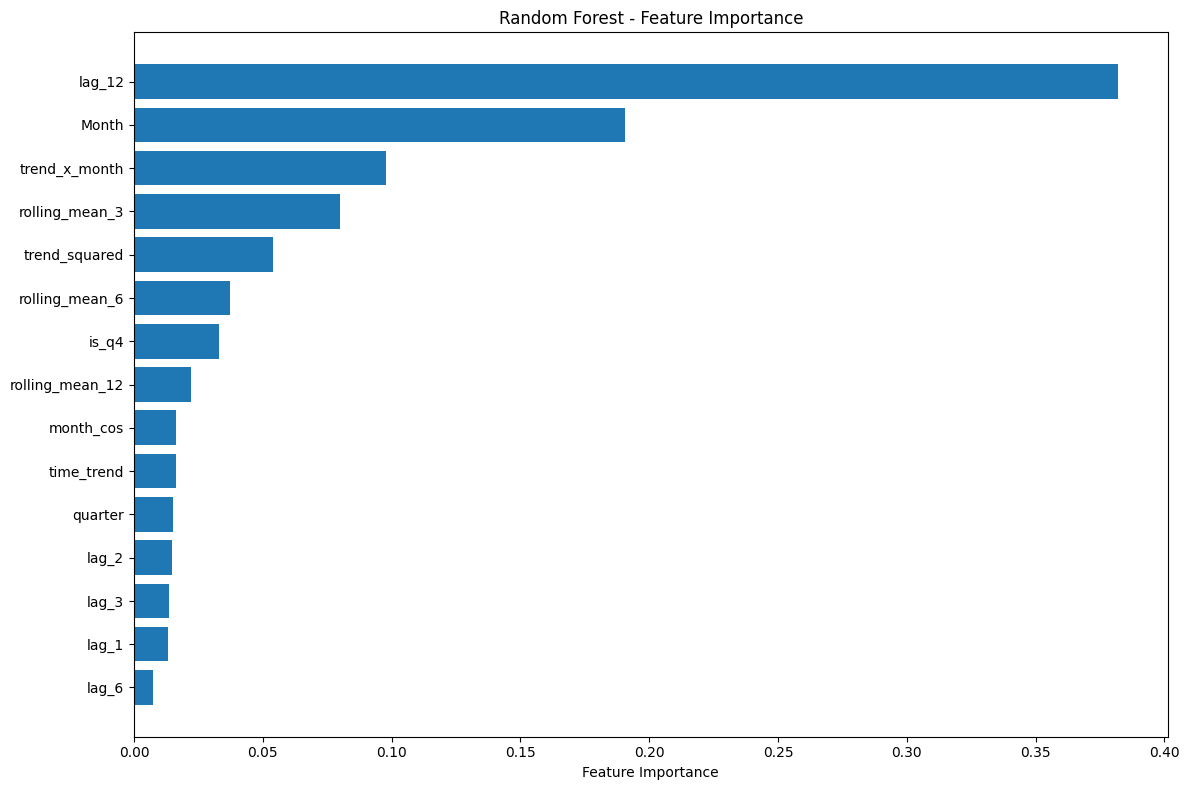


=== PERFORMANCE NA DANYCH TRENINGOWYCH ===
MAE: 4924
MAPE: 17.13%


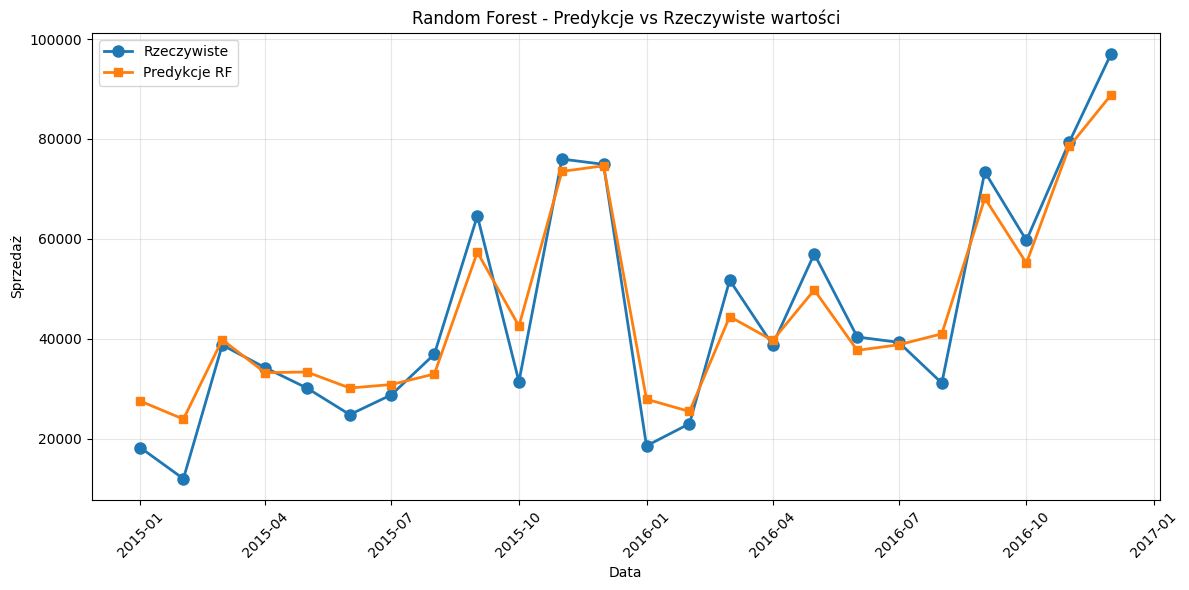

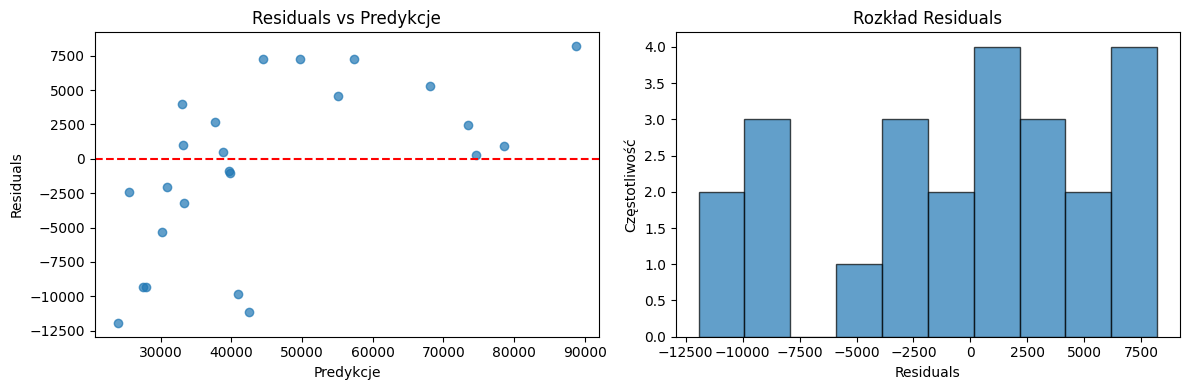


🎯 FINALNY RANDOM FOREST GOTOWY!
📊 Średni błąd na danych treningowych: 17.1% MAPE
🔥 Model gotowy do predykcji na 2017!
Model zapisany jako 'final_random_forest_model.pkl'


In [52]:
# Wybierzmy Random Forest jako najlepszy model i wytrenujmy go na wszystkich danych
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

print("=== TRENOWANIE FINALNEGO RANDOM FOREST ===")

# 1. Hyperparameter tuning dla Random Forest
rf_param_grid = {
   'n_estimators': [30, 50, 100],
   'max_depth': [3, 5, 7, None],
   'min_samples_split': [2, 5, 10],
   'min_samples_leaf': [1, 2, 4],
   'max_features': ['sqrt', 'log2', None]
}

# Użyjemy prostszego gridsearch z małą liczbą kombinacji ze względu na mały dataset
rf_simple_params = {
   'n_estimators': [30, 50, 100],
   'max_depth': [3, 5, 7],
   'min_samples_split': [2, 5],
   'random_state': [42]
}

# GridSearch z TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
rf_grid = GridSearchCV(
   RandomForestRegressor(random_state=42),
   rf_simple_params,
   cv=tscv,
   scoring='neg_mean_absolute_error',
   n_jobs=-1,
   verbose=1
)

print("Szukam najlepszych parametrów...")
rf_grid.fit(X, y)

print(f"Najlepsze parametry: {rf_grid.best_params_}")
print(f"Najlepszy wynik CV MAE: {-rf_grid.best_score_:.0f}")

# 2. Finalny model z najlepszymi parametrami
final_rf = rf_grid.best_estimator_
print(f"\nFinalny Random Forest: {final_rf}")

# 3. Feature importance
feature_importance = final_rf.feature_importances_
importance_df = pd.DataFrame({
   'feature': features,
   'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n=== TOP 10 NAJWAŻNIEJSZYCH CECH ===")
for i, row in importance_df.head(10).iterrows():
   print(f"{row['feature']:20s}: {row['importance']:.4f}")

# 4. Wizualizacja feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 5. Sprawdźmy predykcje na danych treningowych
train_predictions = final_rf.predict(X)
train_mae = mean_absolute_error(y, train_predictions)
train_mape = mean_absolute_percentage_error(y, train_predictions) * 100

print(f"\n=== PERFORMANCE NA DANYCH TRENINGOWYCH ===")
print(f"MAE: {train_mae:.0f}")
print(f"MAPE: {train_mape:.2f}%")

# 6. Wizualizacja predykcji vs rzeczywiste wartości
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Order Month'], y, 'o-', label='Rzeczywiste', linewidth=2, markersize=8)
plt.plot(monthly_sales['Order Month'], train_predictions, 's-', label='Predykcje RF', linewidth=2, markersize=6)
plt.xlabel('Data')
plt.ylabel('Sprzedaż')
plt.title('Random Forest - Predykcje vs Rzeczywiste wartości')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Analiza residuals
residuals = y - train_predictions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(train_predictions, residuals, alpha=0.7)
plt.xlabel('Predykcje')
plt.ylabel('Residuals')
plt.title('Residuals vs Predykcje')
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Częstotliwość')
plt.title('Rozkład Residuals')

plt.tight_layout()
plt.show()

print(f"\n🎯 FINALNY RANDOM FOREST GOTOWY!")
print(f"📊 Średni błąd na danych treningowych: {train_mape:.1f}% MAPE")
print(f"🔥 Model gotowy do predykcji na 2017!")

# Zapisz model (opcjonalnie)
import joblib
joblib.dump(final_rf, 'final_random_forest_model.pkl')
print("Model zapisany jako 'final_random_forest_model.pkl'")

In [53]:
# DODAJ TO do lepszej oceny:
# filepath: c:\Users\miche\Desktop\deepsense\validation_test.py

# Prawdziwa walidacja - użyj ostatnich miesięcy jako test
split_date = monthly_sales['Order Month'].quantile(0.8)  # 80% train, 20% test
train_mask = monthly_sales['Order Month'] < split_date
test_mask = monthly_sales['Order Month'] >= split_date

X_train_real = X[train_mask]
X_test_real = X[test_mask] 
y_train_real = y[train_mask]
y_test_real = y[test_mask]

# Trenuj na train, testuj na test
rf_test = RandomForestRegressor(**final_rf.get_params())
rf_test.fit(X_train_real, y_train_real)
test_preds = rf_test.predict(X_test_real)

test_mape = mean_absolute_percentage_error(y_test_real, test_preds) * 100
print(f"Prawdziwy MAPE (out-of-sample): {test_mape:.2f}%")

Prawdziwy MAPE (out-of-sample): 27.68%
